# Import

In [1]:
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [4]:
pip install "ray[tune]"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install -U ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [52]:
import numpy as np
import pandas as pd
import json
import os
import mne
import warnings
import re


from ray import tune
from ray.tune.schedulers import ASHAScheduler
from typing import Optional, Dict, Union, Tuple

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time

from scipy.fft import fft
from scipy.signal import detrend, butter, filtfilt
import pywt

from skimage.transform import resize
from skimage import img_as_float, img_as_ubyte

import matplotlib.pyplot as plt

# Data Import

In [7]:
def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()
    return data

def read_json_dicts(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

# Preprocessing

In [8]:
def preprocess_eegnet_minimal(eeg_data, fs, lowcut=1.0, highcut=40.0, order=5):
    """
    Applies minimal preprocessing suitable for models like EEGNet:
    Bandpass filtering and channel-wise standardization.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        lowcut (float): Lower cutoff frequency for bandpass filter (Hz).
        highcut (float): Upper cutoff frequency for bandpass filter (Hz).
        order (int): Order of the Butterworth filter.

    Returns:
        np.ndarray: Preprocessed EEG data (n_channels, n_timesteps).
    """
    n_channels, n_timesteps = eeg_data.shape
    processed_data = np.zeros_like(eeg_data)

    # 1. Bandpass Filter Design
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Ensure frequency bounds are valid
    if low <= 0 or high >= 1:
         print(f"Warning: Filter frequencies ({lowcut}Hz, {highcut}Hz) are invalid for Nyquist freq {nyq}Hz. Adjusting or skipping filter.")
         # Option: Skip filtering or adjust bounds
         b, a = None, None # Indicate filter skip
    else:
        try:
            b, a = butter(order, [low, high], btype='band')
        except ValueError as e:
            print(f"Warning: Could not design Butterworth filter (order={order}, freqs=[{low}, {high}]). Skipping filter. Error: {e}")
            b, a = None, None


    # 2. Apply Filter and Standardize Channel by Channel
    for i_ch in range(n_channels):
        channel_data = eeg_data[i_ch, :]

        # Apply filtering if filter design was successful
        if b is not None and a is not None:
             try:
                 filtered_data = filtfilt(b, a, channel_data)
             except Exception as e:
                 print(f"Warning: Filtering failed for channel {i_ch}. Using original data for this channel. Error: {e}")
                 filtered_data = channel_data # Use original if filtering fails
        else:
             filtered_data = channel_data # Use original if filter wasn't designed

        # Standardize (z-score normalization)
        mean = np.mean(filtered_data)
        std = np.std(filtered_data)
        if std > 1e-9: # Avoid division by zero
            processed_data[i_ch, :] = (filtered_data - mean) / std
        else:
            processed_data[i_ch, :] = filtered_data - mean # Only center if std is zero

    return processed_data

In [9]:
def calculate_td_psd_features(epoch_data, fs, power_lambda=0.1, epsilon=1e-9):
    """
    Calculates the 7 TD-PSD features for a single EEG epoch (single channel).
    Based on equations in Amini et al., 2021.

    Args:
        epoch_data (np.ndarray): 1D numpy array for a single channel epoch.
        fs (float): Sampling frequency of the epoch data.
        power_lambda (float): Lambda for power transform normalization.
        epsilon (float): Small value to prevent log(0) or division by zero.

    Returns:
        np.ndarray: Array containing the 7 log-transformed TD-PSD features.
                    Returns NaNs if calculation fails.
    """
    n_samples = len(epoch_data)
    if n_samples == 0:
        return np.full(7, np.nan)

    # Detrend the signal (optional but often good practice)
    signal = detrend(epoch_data)

    # 1. Calculate Power Spectrum and Moments
    try:
        # FFT
        X = fft(signal)
        # Power Spectrum (One-sided, ignoring DC for moments perhaps?)
        # Frequencies for moments k: corresponds to frequency bins
        freqs = np.fft.fftfreq(n_samples, 1/fs)
        # Power spectrum P[k] = |X[k]|^2 / N
        P = np.abs(X)**2 / n_samples

        # Calculate moments m0, m2, m4
        # m_n = sum(f^n * P(f)) df - approximated by sum(k^n * P[k])
        # We use the magnitude of frequencies for k, ignore negative freqs?
        # Let's use Hjorth parameters definition based on time-domain variance
        # m0 = variance(signal) = total power (approx)
        m0_bar = np.sum(signal**2) / n_samples # Variance = mean square if mean is zero
        if m0_bar < epsilon: m0_bar = epsilon

        # m2 = variance of first derivative (activity)
        delta_x = np.diff(signal, n=1) * fs # Scale by fs? Hjorth doesn't explicitly scale by fs
        m2_bar = np.sum(delta_x**2) / (n_samples -1) # Use n_samples-1?
        if m2_bar < epsilon: m2_bar = epsilon


        # m4 = variance of second derivative (mobility)
        delta2_x = np.diff(signal, n=2) * (fs**2) # Scale by fs^2?
        m4_bar = np.sum(delta2_x**2) / (n_samples -2)
        if m4_bar < epsilon: m4_bar = epsilon


        # Apply power transform (Box-Cox with lambda=0 is log, this is slightly different)
        m0 = (m0_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m0_bar)
        m2 = (m2_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m2_bar)
        m4 = (m4_bar**power_lambda - 1) / power_lambda if power_lambda != 0 else np.log(m4_bar)

        # Ensure moments are positive after transform for log
        m0 = max(m0, epsilon)
        m2 = max(m2, epsilon)
        m4 = max(m4, epsilon)


    except Exception as e:
        print(f"Error calculating moments: {e}")
        return np.full(7, np.nan)

    features = np.zeros(7)

    # 2. Calculate Features f1, f2, f3
    try:
        features[0] = np.log(m0) # f1 = log(m0)
        # Check for valid subtractions
        if m0 <= m2: m0 = m2 + epsilon
        if m0 <= m4: m0 = m4 + epsilon
        features[1] = np.log(m0 - m2) # f2 = log(m0 - m2)
        features[2] = np.log(m0 - m4) # f3 = log(m0 - m4)

    except Exception as e:
         print(f"Error calculating f1, f2, f3: {e}")
         features[:3] = np.nan


    # 3. Calculate Feature f4 (Sparseness)
    try:
        denominator_sqrt = np.sqrt(max(m0 - m2, epsilon)) * np.sqrt(max(m0 - m4, epsilon))
        if denominator_sqrt < epsilon: denominator_sqrt = epsilon
        features[3] = np.log(m0 / denominator_sqrt) # f4 = log(S) = log(m0 / sqrt((m0-m2)(m0-m4)))
    except Exception as e:
         print(f"Error calculating f4 (Sparseness): {e}")
         features[3] = np.nan

    # 4. Calculate Feature f5 (Irregularity Factor - IF)
    # IF = (m4/m2) / (m2/m0) based on Hjorth parameters 'complexity'
    # Paper formula: sqrt(m4/m2) / sqrt(m2/m0) => m0*m4 / m2^2
    try:
        if m2 < epsilon: m2 = epsilon
        if_val = (m0 * m4) / (m2**2)
        features[4] = np.log(max(if_val, epsilon)) # f5 = log(IF)
    except Exception as e:
        print(f"Error calculating f5 (IF): {e}")
        features[4] = np.nan

    # 5. Calculate Feature f6 (Covariance - COV)
    # COV = std_dev / mean
    try:
        mean_val = np.mean(signal)
        std_dev_val = np.std(signal)
        if abs(mean_val) < epsilon: mean_val = np.sign(mean_val) * epsilon if mean_val != 0 else epsilon
        cov_val = std_dev_val / mean_val
        features[5] = np.log(max(abs(cov_val), epsilon)) # Log of magnitude? Paper isn't explicit if COV can be negative. Let's take abs.
    except Exception as e:
        print(f"Error calculating f6 (COV): {e}")
        features[5] = np.nan


    # 6. Calculate Feature f7 (Teager Energy Operator - TEO)
    try:
        # TEO(x[j]) = x[j]^2 - x[j-1]x[j+1]
        # Need to handle boundaries (pad or slice)
        teo_vals = signal[1:-1]**2 - signal[:-2] * signal[2:]
        sum_teo = np.sum(teo_vals)
        features[6] = np.log(max(abs(sum_teo), epsilon)) # Log of magnitude? Sum can be negative. Paper isn't explicit. Taking abs.
    except Exception as e:
        print(f"Error calculating f7 (TEO): {e}")
        features[6] = np.nan

    return features

In [10]:
def preprocess_amini(eeg_data, fs, target_fs=256, target_duration_sec=180, epoch_len=256):
    """
    Preprocesses raw EEG data according to Amini et al. (2021).
    Selects time window, downsamples (if needed), segments, extracts TD-PSD features,
    and averages features across epochs for each channel.

    Args:
        eeg_data (np.ndarray): Raw EEG data (n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        target_fs (int): Target sampling frequency (default: 256 Hz).
        target_duration_sec (int): Duration of the segment to analyze (default: 180s).
        epoch_len (int): Length of epochs for feature calculation (default: 256 samples).

    Returns:
        np.ndarray: Feature matrix (n_channels, 7), or None if error.
                   Returns NaNs for channels/features where calculation failed.
    """
    n_channels, n_timesteps = eeg_data.shape

    # 1. Select Time Window (e.g., 60s to 60s + target_duration_sec)
    start_sample = int(60 * fs) # Example: start at 60 seconds
    end_sample = start_sample + int(target_duration_sec * fs)
    if end_sample > n_timesteps:
        print(f"Warning: Data duration ({n_timesteps/fs:.2f}s) is less than required analysis window ({target_duration_sec+60}s). Using available data.")
        end_sample = n_timesteps
    if start_sample >= end_sample:
         print(f"Error: Invalid time window selection.")
         return None
    eeg_segment = eeg_data[:, start_sample:end_sample]

    # 2. Downsample (if necessary)
    if fs != target_fs:
        from scipy.signal import resample
        num_samples_resampled = int(eeg_segment.shape[1] * (target_fs / fs))
        try:
            eeg_resampled = resample(eeg_segment, num_samples_resampled, axis=1)
            current_fs = target_fs
            print(f"Resampled data from {fs}Hz to {target_fs}Hz. New shape: {eeg_resampled.shape}")
        except Exception as e:
            print(f"Error during resampling: {e}")
            return None
    else:
        eeg_resampled = eeg_segment
        current_fs = fs

    # 3. Segment into epochs and Calculate Features
    n_channels_res, n_timesteps_res = eeg_resampled.shape
    num_epochs = n_timesteps_res // epoch_len
    if num_epochs == 0:
        print(f"Error: Resampled data is shorter ({n_timesteps_res} samples) than epoch length ({epoch_len}). Cannot extract features.")
        return None

    all_channel_features = []
    for i_ch in range(n_channels_res):
        channel_data = eeg_resampled[i_ch, :]
        epoch_features_list = []
        for i_epoch in range(num_epochs):
            start = i_epoch * epoch_len
            end = start + epoch_len
            epoch = channel_data[start:end]
            features = calculate_td_psd_features(epoch, current_fs)
            if not np.isnan(features).all(): # Only add if calculation didn't fail completely
                epoch_features_list.append(features)

        if not epoch_features_list: # If no features calculated for this channel
             avg_features = np.full(7, np.nan)
        else:
            # Average features across valid epochs for the channel
            avg_features = np.nanmean(np.array(epoch_features_list), axis=0)
        all_channel_features.append(avg_features)

    # Output shape: (n_channels, 7)
    final_features = np.array(all_channel_features)
    # Optional: Flatten to a single vector per subject if needed by the specific model implementation
    # final_features = final_features.flatten() # Shape: (n_channels * 7)
    return final_features

# Models

In [11]:
class Amini_Adapted_CNN(nn.Module):
    """
    Adapted CNN model based on the structure described in Amini et al. (2021).
    Original paper uses 7 TD-PSD features as input. This adaptation takes raw EEG
    (n_channels, n_timesteps) as input using 1D convolutions.
    Specific parameters (kernel sizes, filter numbers) are assumptions based on
    common practices as they were not detailed for raw EEG in the paper.
    """
    def __init__(self, n_channels, n_timesteps, num_classes, dropout_rate=0.5):
        super(Amini_Adapted_CNN, self).__init__()
        self.n_channels = n_channels
        self.n_timesteps = n_timesteps
        self.num_classes = num_classes

        # Convolutional Layer(s) - Example: One Conv1D layer
        # Input shape: (batch_size, n_channels, n_timesteps)
        # Output shape: (batch_size, out_channels, new_timesteps)
        # Using a relatively large kernel for initial temporal feature extraction
        self.conv1_out_channels = 16
        self.conv1_kernel_size = 64 # Example kernel size
        self.conv1_stride = 16      # Example stride for downsampling
        self.conv1 = nn.Conv1d(in_channels=n_channels,
                               out_channels=self.conv1_out_channels,
                               kernel_size=self.conv1_kernel_size,
                               stride=self.conv1_stride)
        self.bn1 = nn.BatchNorm1d(self.conv1_out_channels)

        # Calculate the output size after convolution and pooling (if any)
        # Assuming no pooling here, just convolution
        conv1_out_timesteps = (n_timesteps - self.conv1_kernel_size) // self.conv1_stride + 1
        self.fc1_input_features = self.conv1_out_channels * conv1_out_timesteps

        # Fully Connected Layers (mimicking Figure 10 structure)
        # Paper shows 3 FC layers before Softmax/Classification
        self.fc1_hidden_units = 128 # Example hidden units
        self.fc2_hidden_units = 64  # Example hidden units

        self.fc1 = nn.Linear(self.fc1_input_features, self.fc1_hidden_units)
        self.fc2 = nn.Linear(self.fc1_hidden_units, self.fc2_hidden_units)
        self.fc3 = nn.Linear(self.fc2_hidden_units, num_classes) # Output layer

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timesteps)

        # Convolution -> BatchNorm -> Activation
        x = F.relu(self.bn1(self.conv1(x)))
        # x shape: (batch_size, conv1_out_channels, conv1_out_timesteps)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # x shape: (batch_size, fc1_input_features)

        # Fully Connected Layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output Layer (Logits)
        x = self.fc3(x)
        # x shape: (batch_size, num_classes)
        # Note: Softmax is typically applied outside the model, often in the loss function (e.g., CrossEntropyLoss)

        return x

# Training

In [12]:
# --- Modified Generic Training Function with Validation ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Generic function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader or None): DataLoader for the validation data. If None, validation is skipped.
        criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train for.
        device (torch.device): The device to train on (CPU or CUDA).

    Returns:
        None: Prints training and validation progress information directly.
    """
    model.to(device) # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval() # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad(): # Disable gradient calculations during validation
                for val_inputs, val_labels in val_loader:
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

        # Note: model is already set back to train() mode at the start of the next epoch loop iteration

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")
    # --- Consider saving the best model based on validation performance ---
    # (Logic for tracking best val_accuracy/lowest val_loss and saving model state_dict would go here)

# Evaluation

In [42]:
def evaluate_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    class_names: list = None
) -> pd.DataFrame:
    """
    Evaluate a single PyTorch model on a dataset.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the evaluation set.
        device: torch.device (e.g., "cpu" or "cuda").
        num_classes: Number of output classes.
        class_names: Optional list of class labels (for report index).

    Returns:
        report_df: DataFrame containing precision, recall, f1-score, support.
    """
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())

    # 1. Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f}%\n")

    # 2. Classification report
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).transpose()
    print("Classification Report:")
    print(report_df[["precision", "recall", "f1-score", "support"]], "\n")

    # 3. Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm, "\n")

    # 4. ROC curve (micro-average)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_probs_arr = np.array(y_probs)
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs_arr.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"Micro-average ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.title("Micro-Averaged ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return report_df

# Running

## Import the data

In [17]:
folder_path_val = './fixed_data_aug/validate'
folder_path_test = './fixed_data_aug/test'
folder_path_train = './fixed_data_aug/train'
file_path_labels = './fixed_data_aug/labels.json'

# Load test data and labels
data_val = collect_eeg_data(folder_path_val)
data_test = collect_eeg_data(folder_path_test)
data_train = collect_eeg_data(folder_path_train)
data_labels = read_json_dicts(file_path_labels)

## Preprocessing

First, we match the labels with the data sets

In [18]:
# 1. Strip 'test/' or 'train/' prefix from data_labels.file_name
data_labels['file_name'] = data_labels['file_name'].str.replace(r'^(test/|train/)', '', regex=True)

# Build a mapping from base filename → label
label_map = dict(zip(data_labels['file_name'], data_labels['label']))

# 2. Create y_val and filter data_val
y_val = {}
for fn in list(data_val.keys()):
    if fn in label_map:
        y_val[fn] = label_map[fn]
# keep only matched entries in data_val
data_val = {fn: data_val[fn] for fn in y_val}

# 3. Create y_test and filter data_test
y_test = {}
for fn in list(data_test.keys()):
    if fn in label_map:
        y_test[fn] = label_map[fn]
data_test = {fn: data_test[fn] for fn in y_test}

# 4. Create y_train and filter data_train, handling augmented filenames
def get_base_filename(fn: str) -> str:
    """
    Remove augmentation suffix (_amplitude_scale, _noise, _time_shift) before '.set'.
    E.g. 'sub-002_eeg_chunk_0_noise.set' → 'sub-002_eeg_chunk_0.set'
    """
    return re.sub(r'_(amplitude_scale|noise|time_shift)(?=\.set$)', '', fn)

y_train = {}
for fn in list(data_train.keys()):
    base = get_base_filename(fn)
    if base in label_map:
        y_train[fn] = label_map[base]
# keep only matched entries in data_train
data_train = {fn: data_train[fn] for fn in y_train}

Then, we remove the datasets 

In [22]:
# Set sampling frequency and disable bandpass by using lowcut=0 and highcut=fs
fs = 95

print("\n--- Applying Minimal Preprocessing WITHOUT Bandpass Filter (Only Standardization) ---")

# Process TEST set
X_test_processed = []
for fname, eeg in data_test.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_test_processed.append(processed)
print(f"Processed {len(X_test_processed)} test samples; example shape: {X_test_processed[0].shape}")

# Process VALIDATION set
X_val_processed = []
for fname, eeg in data_val.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_val_processed.append(processed)
print(f"Processed {len(X_val_processed)} validation samples; example shape: {X_val_processed[0].shape}")

# Process TRAIN set
X_train_processed = []
for fname, eeg in data_train.items():
    processed = preprocess_eegnet_minimal(eeg, fs)
    X_train_processed.append(processed)
print(f"Processed {len(X_train_processed)} train samples; example shape: {X_train_processed[0].shape}")



--- Applying Minimal Preprocessing WITHOUT Bandpass Filter (Only Standardization) ---
Processed 898 test samples; example shape: (19, 1425)
Processed 877 validation samples; example shape: (19, 1425)
Processed 10644 train samples; example shape: (19, 1425)


We turn datasets into tensors

In [23]:
print("\n--- Converting processed data + labels into tensors & dataloaders ---")

# Helper ─ collect labels in the SAME iteration order as the list was built
def build_xy_tensors(X_processed_list, y_dict):
    """
    Align X and y by dict iteration order, encode y with LabelEncoder,
    and return (X_tensor, y_tensor).
    """
    if not X_processed_list:
        raise ValueError("The processed X list is empty!")

    # Preserve insertion order of the dict (Python 3.7+ guarantees this)
    filenames_order = list(y_dict.keys())

    # Sanity check
    if len(filenames_order) != len(X_processed_list):
        raise RuntimeError(
            f"Mismatch: len(X)={len(X_processed_list)} vs len(y)={len(filenames_order)}. "
            "Check data alignment."
        )

    # Build y list according to the same order we used when filling X_processed
    y_list = [y_dict[fname] for fname in filenames_order]

    # --- Label encoding ---
    # For consistency across splits, fit once on the union of all labels
    global _global_le  # use a single LabelEncoder instance
    if '_global_le' not in globals():
        _global_le = LabelEncoder()
        _global_le.fit(
            list(y_train.values()) +
            list(y_val.values())   +
            list(y_test.values())
        )

    y_encoded = _global_le.transform(y_list)

    # --- Convert to tensors ---
    X_np = np.array(X_processed_list)          # shape: (N, C, T)
    y_np = np.array(y_encoded, dtype=np.int64) # shape: (N,)

    X_tensor = torch.from_numpy(X_np).float()
    y_tensor = torch.from_numpy(y_np)          # long by default if dtype not set

    return X_tensor, y_tensor

# Build tensors for each split
X_train_tensor, y_train_tensor = build_xy_tensors(X_train_processed, y_train)

# Validation split 
if X_val_processed:
    X_val_tensor, y_val_tensor = build_xy_tensors(X_val_processed, y_val)
else:
    X_val_tensor = torch.empty((0, *X_train_tensor.shape[1:]), dtype=torch.float32)
    y_val_tensor = torch.empty((0,), dtype=torch.long)

# Test split
if X_test_processed:
    X_test_tensor, y_test_tensor = build_xy_tensors(X_test_processed, y_test)
else:
    X_test_tensor = torch.empty((0, *X_train_tensor.shape[1:]), dtype=torch.float32)
    y_test_tensor = torch.empty((0,), dtype=torch.long)

# Log shapes
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val  : {X_val_tensor.shape}, y_val  : {y_val_tensor.shape}")
print(f"X_test : {X_test_tensor.shape}, y_test : {y_test_tensor.shape}")



--- Converting processed data + labels into tensors & dataloaders ---
X_train: torch.Size([10644, 19, 1425]), y_train: torch.Size([10644])
X_val  : torch.Size([877, 19, 1425]), y_val  : torch.Size([877])
X_test : torch.Size([898, 19, 1425]), y_test : torch.Size([898])


# Model

In [29]:
class_weight = {
    0: 0.7941,   # A
    1: 0.8360,   # C
    2: 1.8364    # F
}


# ---------- utility: full pipeline for one run ----------
def train_eegnet_pipeline(
    X_train_tensor: torch.Tensor,
    y_train_tensor: torch.Tensor,
    X_val_tensor : Optional[torch.Tensor],
    y_val_tensor : Optional[torch.Tensor],
    X_test_tensor: Optional[torch.Tensor],
    y_test_tensor: Optional[torch.Tensor],
    *,
    learning_rate : float = 1e-3,
    batch_size    : int   = 16,
    optimizer     : str   = "Adam",
    class_weight  : Optional[Union[torch.Tensor, Dict[int, float]]] = class_weight,
    dropout_rate  : float = 0.5,
    num_epochs    : int   = 1,
    weight_decay  : float = 1e-4,             # 新增 L2 强度参数
    device        : torch.device = torch.device("cpu"),
    verbose       : bool  = False
) -> Tuple[nn.Module, Dict[str, DataLoader]]:
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader, test_loader = None, None
    if X_val_tensor is not None and X_val_tensor.shape[0] > 0:
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size,
            shuffle=False
        )
    if X_test_tensor is not None and X_test_tensor.shape[0] > 0:
        test_loader = DataLoader(
            TensorDataset(X_test_tensor, y_test_tensor),
            batch_size=batch_size,
            shuffle=False
        )

    n_channels, n_timesteps = X_train_tensor.shape[1], X_train_tensor.shape[2]
    num_classes = len(_global_le.classes_)
    model = Amini_Adapted_CNN(
        n_channels=n_channels,
        n_timesteps=n_timesteps,
        num_classes=num_classes,
        dropout_rate=dropout_rate
    ).to(device)

    if class_weight is not None:
        if isinstance(class_weight, dict):
            cw_tensor = torch.tensor(
                [class_weight.get(i, 1.0) for i in range(num_classes)],
                dtype=torch.float32,
                device=device
            )
        else:
            cw_tensor = class_weight.to(device)
        criterion = nn.CrossEntropyLoss(weight=cw_tensor)
    else:
        criterion = nn.CrossEntropyLoss()

    opt_name = optimizer.lower()
    if opt_name == "adam":
        optim_obj = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay    # L2 regularization
        )
    elif opt_name == "adamw":
        optim_obj = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
    elif opt_name == "sgd":
        optim_obj = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            momentum=0.9,
            weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Unsupported optimizer {optimizer}")

    train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optim_obj,
        num_epochs,
        device
    )
    return model, {"train": train_loader, "val": val_loader, "test": test_loader}


In [41]:

# initialize best trackers
best_acc = 0.0
best_config = None
best_model = None
best_model_path = './best_model.path'

# Define search space matching the previous Ray Tune setup
tune_space = {
    "learning_rate": np.logspace(-4, -2, num=100),  # continuous log space
    "batch_size":    [16, 24, 32, 40, 48, 56, 64],
    "optimizer":     ["Adam", "AdamW", "SGD"],
    "dropout_rate":  np.linspace(0.3, 0.6, num=100),
    "num_epochs":    [100],
    "weight_decay":  np.logspace(-3, -1, num=50)     # L2 regularization strength
}

# Sample 10 random combinations
drawer = list(ParameterSampler(tune_space, n_iter=10, random_state=42))

# Loop through each sampled config
for idx, config in enumerate(drawer, 1):
    print(f"\n=== Configuration {idx} ===")
    print(config)

    # Extract hyperparameters
    lr        = config["learning_rate"]
    bs        = config["batch_size"]
    opt_name  = config["optimizer"]
    do_rate   = config["dropout_rate"]
    epochs    = config["num_epochs"]
    wd        = config["weight_decay"]

    # Train using the existing pipeline
    model, loaders = train_eegnet_pipeline(
        X_train_tensor, y_train_tensor,
        X_val_tensor,   y_val_tensor,
        X_test_tensor,  y_test_tensor,
        learning_rate=lr,
        batch_size=bs,
        optimizer=opt_name,
        dropout_rate=do_rate,
        num_epochs=epochs,
        weight_decay=wd,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        verbose=False
    )

    # Evaluate on validation set
    val_loader = loaders["val"]
    if val_loader is not None:
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(model.conv1.weight.device), yb.to(model.conv1.weight.device)
                out = model(Xb)
                pred = torch.argmax(out, dim=1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)
        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # Save model if it achieves a new best accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_config = config
            best_model = model
            torch.save(model.state_dict(), best_model_path)
            print(f"--> New best model saved! (acc={best_acc:.2f}%)")

# Print summary of best result
print(f"\n==> Best Validation Accuracy: {best_acc:.2f}%")
print("Best Hyperparameters:", best_config)


=== Configuration 1 ===
{'weight_decay': 0.03556480306223129, 'optimizer': 'AdamW', 'num_epochs': 100, 'learning_rate': 0.0002782559402207126, 'dropout_rate': 0.38484848484848483, 'batch_size': 48}

--- Training Amini_Adapted_CNN ---
Epoch [1/100], Train Loss: 1.0964, Train Acc: 36.75%, Val Loss: 1.1124, Val Acc: 34.89%
Epoch [2/100], Train Loss: 1.0161, Train Acc: 46.47%, Val Loss: 1.3396, Val Acc: 31.13%
Epoch [3/100], Train Loss: 0.7507, Train Acc: 65.50%, Val Loss: 1.5234, Val Acc: 32.04%
Epoch [4/100], Train Loss: 0.5312, Train Acc: 77.63%, Val Loss: 2.3208, Val Acc: 32.38%
Epoch [5/100], Train Loss: 0.3919, Train Acc: 83.80%, Val Loss: 2.7711, Val Acc: 30.44%
Epoch [6/100], Train Loss: 0.2948, Train Acc: 87.97%, Val Loss: 3.6328, Val Acc: 33.18%
Epoch [7/100], Train Loss: 0.2190, Train Acc: 91.54%, Val Loss: 3.5424, Val Acc: 32.38%
Epoch [8/100], Train Loss: 0.1733, Train Acc: 93.40%, Val Loss: 4.2595, Val Acc: 29.76%
Epoch [9/100], Train Loss: 0.1330, Train Acc: 95.30%, Val Los

# Evaluation

Accuracy: 40.48%

Classification Report:
              precision    recall  f1-score     support
A              0.404789  1.000000  0.576299  355.000000
C              0.000000  0.000000  0.000000  213.000000
F              0.000000  0.000000  0.000000  309.000000
accuracy       0.404789  0.404789  0.404789    0.404789
macro avg      0.134930  0.333333  0.192100  877.000000
weighted avg   0.163854  0.404789  0.233279  877.000000 

Confusion Matrix:
[[355   0   0]
 [213   0   0]
 [309   0   0]] 



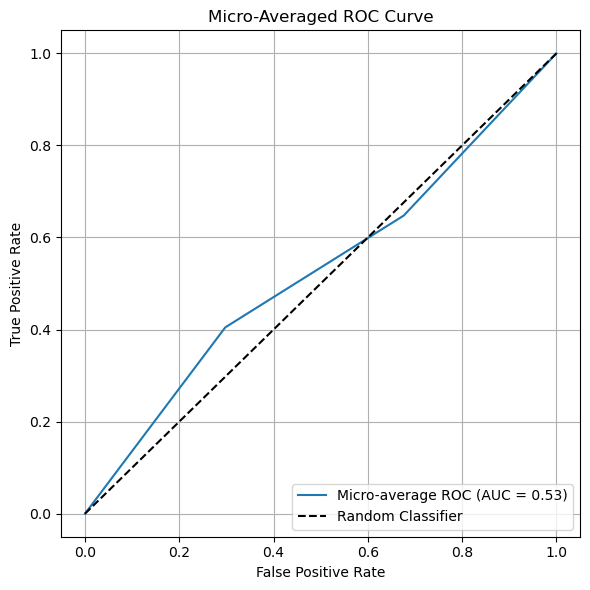

In [53]:
report_df = evaluate_model(
    model=best_model,
    data_loader=val_loader,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_classes=len(_global_le.classes_),
    class_names=_global_le.classes_.tolist()
)
